# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.3)

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import metrics

%matplotlib inline

# Data preprocessing

In [3]:
car_df = pd.read_csv("../data/eda_data.csv")
car_df = car_df.drop(["model", "year", "transmission", "fuelType", "tax", "brand"], axis=1)
car_df

,price,mileage,mpg,engineSize,age,brand_rank,transmission_Manual
0,12500,4.196867,55.4,1.4,4,1,1
1,16500,4.558745,64.2,2.0,5,1,0
2,11000,4.476339,55.4,1.4,5,1,1
3,16800,4.414171,67.3,2.0,4,1,0
4,17300,3.300595,49.6,1.0,2,1,1
...,...,...,...,...,...,...,...
98724,5990,4.869232,58.9,2.0,9,3,1
98725,1799,4.944986,46.3,1.2,13,3,1
98726,1590,4.845098,42.0,1.4,12,3,1
98727,1250,4.917527,46.3,1.2,15,3,1


## train-test split 

In [3]:
car_df.columns

Index(['price', 'mileage', 'mpg', 'engineSize', 'age', 'brand_rank',
       'transmission_Manual'],
      dtype='object')

In [4]:
y = car_df["price"].values
X = car_df.drop(["price"], axis=1).values

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

(78983, 6)
(19746, 6)


## scaling

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build model

In [7]:
import time 

import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [8]:
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
lin_reg = LinearRegression()
ridge_reg = Ridge()
dt_reg = DecisionTreeRegressor(random_state=42)
rf_reg = RandomForestRegressor(random_state=42)

regressors = zip(
    ["XGBRegressor", "LinearRegression", "Ridge", "DecisionTreeRegressor", "RandomForestRegressor"],
    [xgb_reg, lin_reg, ridge_reg, dt_reg, rf_reg]
)

In [9]:
end = 0

for label, model in regressors:
    start = time.time()
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_absolute_error", cv=5)
    scores *= -1
    elapsed_time = time.time() - start
    print("[%s] mae: %0.3f (+/- %0.3f) - %f s" % (label, scores.mean(), scores.std(), elapsed_time))
    end += elapsed_time

print("Elasped time : %f s" %  end)

[XGBRegressor] mae: 1486.877 (+/- 17.729) - 21.646715 s
[LinearRegression] mae: 2975.110 (+/- 9.961) - 1.186373 s
[Ridge] mae: 2975.104 (+/- 9.961) - 0.284070 s
[DecisionTreeRegressor] mae: 1656.486 (+/- 27.226) - 3.700902 s
[RandomForestRegressor] mae: 1366.835 (+/- 11.030) - 285.655326 s
Elasped time : 312.473385 s


# Fine-Tune Model

## Grid Search

In [10]:
parameters = {
    "max_depth": [6, 9, 12],
    "min_child_weight": [1, 2, 4],
    "gamma": [0, 1, 2],
    "subsample": [1.0], 
    "colsample_bytree": [0.8]
}

grid_search = GridSearchCV(estimator=xgb_reg, param_grid=parameters, scoring="neg_mean_absolute_error", cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8], 'gamma': [0, 1, 2],
                         'max_depth': [6, 9, 12], 'min_child_weight': [1, 2, 4],
                         'subsample': [1.0]},
             scoring='neg_mean_absolute_error')

In [11]:
best_score = grid_search.best_score_
best_params = grid_search.best_params_

print("best_score", best_score)
print("best_params", best_params)

best_score -1331.9559449164685
best_params {'colsample_bytree': 0.8, 'gamma': 2, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 1.0}


In [12]:
df = pd.DataFrame(grid_search.cv_results_)
print(df[["params", "mean_test_score", "rank_test_score"]].sort_values("rank_test_score").head().to_string())

                                                                                             params  mean_test_score  rank_test_score
24  {'colsample_bytree': 0.8, 'gamma': 2, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 1.0}     -1331.955945                1
15  {'colsample_bytree': 0.8, 'gamma': 1, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 1.0}     -1331.955956                2
6   {'colsample_bytree': 0.8, 'gamma': 0, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 1.0}     -1331.955957                3
16  {'colsample_bytree': 0.8, 'gamma': 1, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 1.0}     -1335.764267                4
25  {'colsample_bytree': 0.8, 'gamma': 2, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 1.0}     -1335.764267                4


test mae: 1318.165995752873


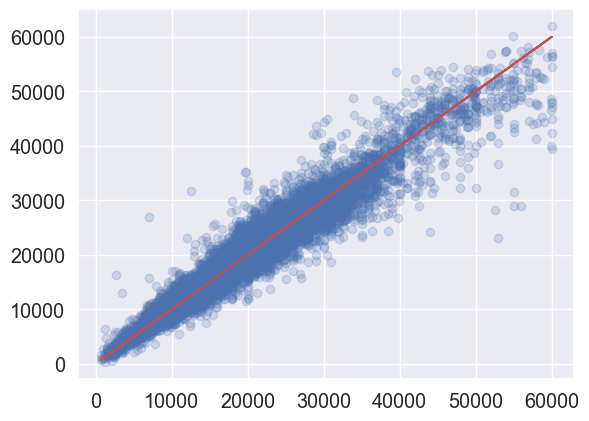

In [13]:
# final_model
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test)

print("test mae:", metrics.mean_absolute_error(y_test, y_pred))

plt.plot(y_test, y_test, "r-")
plt.scatter(y_test, y_pred, alpha=0.2)

# Save Model 

In [14]:
import pickle

filename = "final_model.pkl"
pickle.dump(final_model, open(filename, "wb"))

In [15]:
# #load model
# loaded_model = pickle.load(open(filename, "rb"))
# print(loaded_model.score(X_test, y_test))